# Lab 6. CNN MNIST classification

### 이번 실습은 Convolutional Neural Network 모델을 만들고 이를 이용해 MNIST dataset으로 classification을 진행해보며 CNN의 사용방법을 익혀보겠습니다.

### 이 과정에서 CNN을 사용할 때와 MLP를 사용할 때 어떤 점이 다른지 비교해보면서 CNN의 특징을 살펴보도록 하겠습니다.

### 또한 흑백 이미지 데이터였던 MNIST 뿐만 아니라 칼라 이미지 데이터인 SVHN 데이터를 사용해서 본격적인 이미지 데이터 활용을 해보도록 하겠습니다.





### Drive mount and package import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 6-1. Review for the MNIST Dataset

### Data Prepare

In [ ]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")

# torchvision 이 제공하는 dataset 불러오기
# https://pytorch.org/vision/stable/datasets 에서 class argument 들 확인 가능
mnist_train = datasets.MNIST(
    root=root,                         # 데이터를 읽어오거나 다운로드 할 경로
    train=True,                        # Train data
    download=True,                     # 자동으로 root에서 읽어오기 / 혹은 없다면 다운로드
    transform=transforms.ToTensor()    # pytorch Tensor 형태의 data로 변환
)
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) 

### Train / Val Split

In [ ]:
# data 와 target(레이블) 를 같이 다루는 Dataset class
# idx 를 주면 해당하는 data, target pair 를 transfom 시킨 값을 뱉어냄
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]
    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [ ]:
# Train dataset을 쪼개서 validation dataset을 만드는 함수
# valid_ratio 만큼의 비율의 데이터를 valid data로 만듦
def split_train_valid(dataset, valid_ratio=0.1):# 인풋 데이터셋을 받음, valid_ratio=얼마만큼 valid셋으로 뺄껀지
  n_valid = int(len(dataset) * valid_ratio)         # valid data 개수
  
  train_data = np.array(dataset.data[:-n_valid])      # dataset 중에 뒤에서부터 n_valid 개만큼 뺀 나머지를 train data로 만듦
  valid_data = np.array(dataset.data[-n_valid:])      # dataset 중에 뒤에서부터 n_valid 개만큼을 valid data로 만듦
  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]
  
  # train / valid 로 쪼갠 data, target 들을 pair로 엮어서 다루기 위해 dataset class 로 정의해줌
  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

In [ ]:
print(mnist_train)      # train/val 로 쪼개기 전 데이터 확인
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)    # torvision dataset에서 불러온 train dataset을 train / val 로 쪼갬

# DataLoader 정의 = >데이터를 편하게 불러옴
#트레인, 벨리드 , 테스트 나누기
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)    # train 시에는 데이터를 shuffle 해줌
valid_loader = DataLoader(dataset=mnist_valid, batch_size=64, shuffle=False, drop_last=True)   
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()


### Data Check

In [ ]:
sample_x, sample_y = mnist_train[0]     # train 데이터 example: x=이미지, y=label
print(sample_x.shape) # 체널이 앞에 나옴으로 28by28by1임
print(sample_y)

torch.Size([1, 28, 28])
tensor(5)


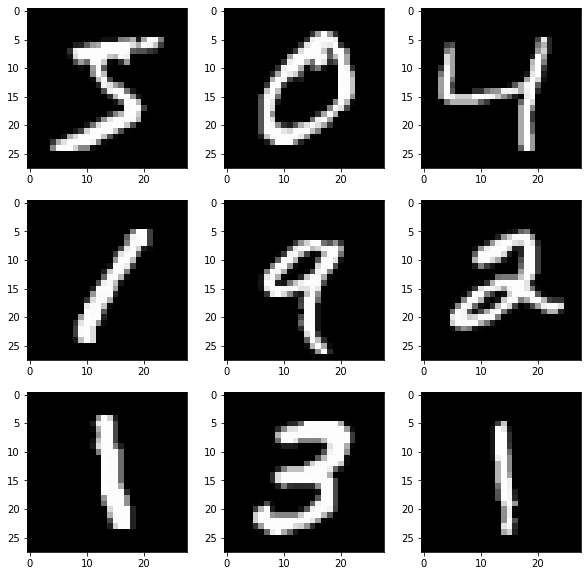

In [ ]:
# train data example visualization
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  img = mnist_train[i][0] #  sample x

  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img.reshape(28, 28), cmap="gray")
fig.show()

## 6-2. CNN Classification


### Simple CNN Model

In [ ]:
## 간단한 CNN Classifier 모델

class Lion_MNIST_CNN_Classifier(nn.Module):
  def __init__(self, n_class=10):#n_class=>우리가 최종적으로  classification해야하는 숫자가 몇개인지
    super().__init__()

    ## filter visulaization 을 위해 layer 마다 따로 정의
    ## nn.Conv2d : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d
    ## nn.Maxpool2d : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d
    # conv레이어 in_channels => 인풋에서 체널이 얼마나 나왔는지, 
    # out_channels=> 아웃풋 체널
    # kernel_size=> 커널 사이즈 |하지만 여기는 정사각형이기에 커널 사이즈는 하나!
    # padding=> 아웃풋 피처의 크기 결정 2=> 양쪽에 두개
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
    # 학습파라미터 가있기에 conv2와 conv3 등 불러올때 결과가 다 달라짐으로 나누어놓음
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.relu = nn.ReLU()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#maxpool레이어
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(3*3*32, 32)
    self.fc2 = nn.Linear(32, 10)         # classification을 수행할 label 은 총 10가지


    ## nn.Sequential 을 사용하면 더 깔끔하게 network를 정의할 수 있음
    # 나중에 크기가 안맞아서 안넘어가게 되면 앞에서 인코딩한게 의미가 없음 그래서 일단 주석 처리
    # self.model = nn.Sequential(
    #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
    #     nn.ReLU(),
    #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Flatten(),
    #     nn.Linear(3*3*32, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 10),
    # )

    
  def forward(self, x, visualize_filter=False):
    #conv레이어가 작동후 얼마나 바뀌었는지 확인하고 싶으면 visualize_filter를 true로 바꾸면 확인 가능
    conv1 = self.conv1(x)
    _conv1 = self.pool(self.relu(conv1))
    conv2 = self.conv2(_conv1)
    _conv2 = self.pool(self.relu(conv2))
    conv3 = self.conv3(_conv2)
    _conv3 = self.pool(self.relu(conv3))
    conv3_vec = self.flatten(_conv3)
    fc1 = self.fc1(conv3_vec)
    out = self.fc2(self.relu(fc1))

    ## nn.Sequential 을 사용할 경우
    # out = self.mode(x)

    if not visualize_filter:    # 일반적인 경우
      return out
    else:                       # visualzie_filter = True --> conv filter 가 생긴 것을 보고 싶을 때
      return conv1, conv2, conv3,out

In [ ]:
cnn = Lion_MNIST_CNN_Classifier()

In [ ]:
## CNN 구조를 확인하기 위한 테스트 데이터
#차원 추가로 1/1/28/28 로 됨| 우리가 일반적으로 연산 할때 batch단위로 하는데 이 batch를 맟춰추기 위해서 앞에 1추가
sample_x = mnist_valid[0][0].unsqueeze(dim=0)    # unsqeeze : 데이터를 1차원 확장 --> dim 에 해당하는 차원으로
print(sample_x.shape)                            # CNN의 input 이 (batch, channels, H, W) 꼴이므로 맞춰주기 위해 (batch=1)로 차원을 확장

torch.Size([1, 1, 28, 28])


In [ ]:
conv1, conv2, conv3,out = cnn(sample_x, visualize_filter=True)# filter 크기를 확인하기 위해 true로!
print(conv1.shape, conv2.shape, conv3.shape, out.shape)

torch.Size([1, 32, 28, 28]) torch.Size([1, 32, 14, 14]) torch.Size([1, 32, 7, 7]) torch.Size([1, 10])


### Training CNN

In [ ]:
start_time = time.time()      # 현재 시각을 기록
start_time

1653485814.7315156

In [ ]:
time_interval = time.time() - start_time     # start_time에서 지금까지 얼마나 시간이 흘렀는지를 초로 표현
time_interval

9.853541612625122

In [ ]:
## Trainer class 정의

class Trainer(nn.Module):
  def __init__(self, model, opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
    """
      Args:
        model: 사용할 classification model
        n_class: class 개수
        opt: optimizer
        lr: learning rate
        has_scheduler: learning rate scheduler 사용 여부
        device: 사용할 device (cpu/cuda)
    """
    super().__init__()

    self.model = model                            # class 개수를 input으로 classification model 정의
    self.loss = nn.CrossEntropyLoss()             # loss function 정의
    
    self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
    self.has_scheduler = has_scheduler            # scheduler 사용여부 
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device                          # 사용할 device

  def _get_optimizer(self, opt, lr=0.001):
    """
      Args:
        opt: optimizer
        lr: learning rate
    """
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
#     self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
    self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

  def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5):
    """
      네트워크를 학습시키는 함수
      Args:
        train_loader: 학습에 사용할 train dataloader
        valid_loader: validation에 사용할 dataloader
        max_epochs: 학습을 진행할 총 epoch 수
        disp_epochs: 학습 log를 display 할 epoch 주기
    """
    print("===== Train Start =====")
    start_time = time.time()   
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch(train_loader)
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
      history["train_acc"].append(train_acc)        #
      history["valid_loss"].append(valid_loss)      #
      history["valid_acc"].append(valid_acc)        #

      if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
        self.scheduler.step()
      #이 epoch까지 실행을 시키는 동안 시간이 얼마나 걸렸는지 확인
      if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}, time: {time.time()-start_time:>3f}")
        start_time = time.time()   

    self.plot_history(history)       # 그래프 출력

  def _train_epoch(self, train_loader):
    """
      model를 training set 한 epoch 만큼 학습시키는 함수
      Args:
        train_loader: 학습에 사용할 train dataloader
      Returns:
        training set 한 epoch의 평균 loss, 평균 accuracy
    """
    epoch_loss, epoch_acc = 0, 0
    self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
    for (x, y) in train_loader:        # x: data, y:label
        
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)            # model이 예측한 label 
      loss = self.loss(y_hat, y)       # 그 label을 실제 y와 비교

      self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
      loss.backward()                  # 
      self.optimizer.step()            # 

      epoch_loss += loss.to("cpu").item()    
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(train_loader)  
    epoch_acc /= len(train_loader)

    return epoch_loss, epoch_acc
  
  def _valid_epoch(self, valid_loader): 
    """
      현재 model의 성능을 validation set에서 측정하는 함수
      Args:
        valid_loader: 학습에 사용할 valid dataloader
      Returns:
        validation set 의 평균 loss, 평균 accuracy
    """
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
    with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
                                      # 그래서 valid가 태스트에 영향을 주지 않음
      for (x, y) in valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(valid_loader)
    epoch_acc /= len(valid_loader)

    return epoch_loss, epoch_acc

  def plot_history(self, history):
    """
      history에 저장된 model의 성능을 graph로 plot
      Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
                 각 item 들은 epoch 단위의 성능 history의 list
    """
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()

  def test(self, test_loader):
    """
      현재 model의 성능을 test set에서 측정하는 함수
      Args:
        test_loader: 학습에 사용할 test dataloader
      Returns:
        test set 의 평균 loss, 평균 accuracy
    """
    print("===== Test Start =====")
    start_time = time.time()
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
    with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
      for (x, y) in test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(test_loader)
    epoch_acc /= len(test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}, time: {time.time()-start_time:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.306775, train acc: 0.902524, valid loss: 0.080352, valid acc: 0.975638, time: 7.378652
Epoch: 1, train loss: 0.073503, train acc: 0.976683, valid loss: 0.070564, valid acc: 0.977655, time: 3.940647
Epoch: 2, train loss: 0.054970, train acc: 0.982744, valid loss: 0.046739, valid acc: 0.985551, time: 3.895812
Epoch: 3, train loss: 0.043695, train acc: 0.985839, valid loss: 0.044267, valid acc: 0.987567, time: 3.968643
Epoch: 4, train loss: 0.036117, train acc: 0.988453, valid loss: 0.037279, valid acc: 0.989415, time: 3.951085
Epoch: 5, train loss: 0.032093, train acc: 0.989509, valid loss: 0.034368, valid acc: 0.989247, time: 3.974460
Epoch: 6, train loss: 0.027473, train acc: 0.991381, valid loss: 0.032539, valid acc: 0.989919, time: 3.989295
Epoch: 7, train loss: 0.023844, train acc: 0.992345, valid loss: 0.034808, valid acc: 0.991095, time: 4.018425
Epoch: 8, train loss: 0.020028, train acc: 0.993253, valid loss: 0.029564, valid acc: 0.

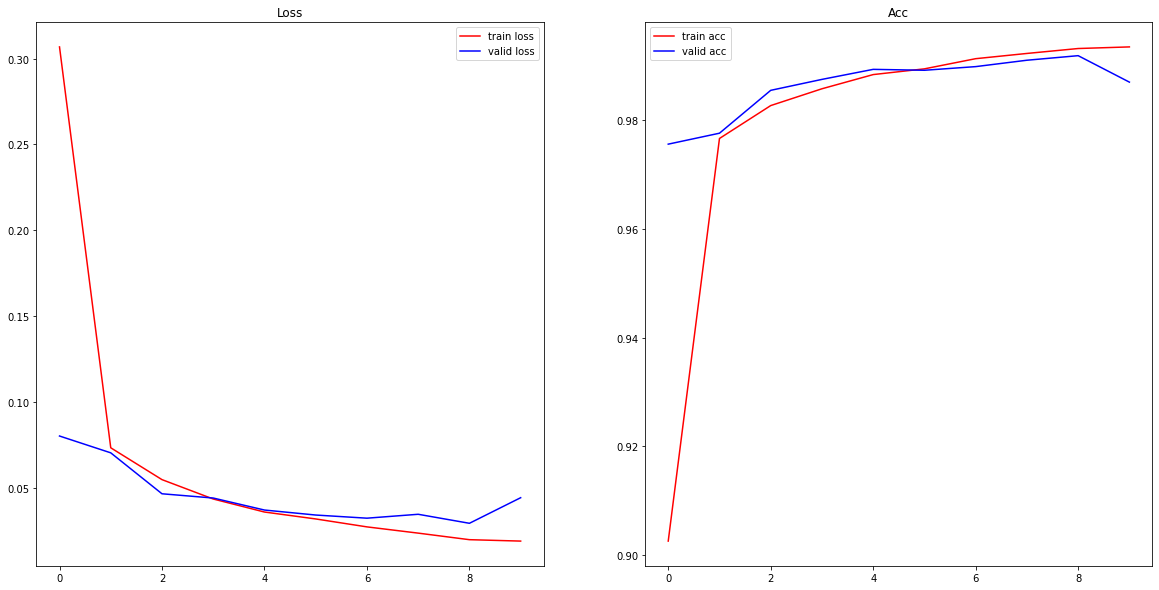

In [ ]:
device = "cuda"
cnn = Lion_MNIST_CNN_Classifier(n_class=10)
trainer = Trainer(model=cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(test_loader)

### Model Save/Load

In [ ]:
## State dict
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in cnn.state_dict():
    print(f"{param_tensor}, \t {cnn.state_dict()[param_tensor].size()}")

Model's state_dict:
conv1.weight, 	 torch.Size([32, 1, 5, 5])
conv1.bias, 	 torch.Size([32])
conv2.weight, 	 torch.Size([32, 32, 3, 3])
conv2.bias, 	 torch.Size([32])
conv3.weight, 	 torch.Size([32, 32, 3, 3])
conv3.bias, 	 torch.Size([32])
fc1.weight, 	 torch.Size([32, 288])
fc1.bias, 	 torch.Size([32])
fc2.weight, 	 torch.Size([10, 32])
fc2.bias, 	 torch.Size([10])


In [ ]:
# Save
model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
#cnn저장이 아닌 cnn_dict()를 저장하는것! 
torch.save(cnn.state_dict(), os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth"))

In [ ]:
# 학습되지 않은 model test 성능

device = "cuda"
cnn_load = Lion_MNIST_CNN_Classifier(n_class=10)
trainer_not_load = Trainer(model=cnn_load, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_not_load.test(test_loader)

===== Test Start =====
Test loss: 2.309525, Test acc: 0.089143, time: 0.885366


In [ ]:
# Load model

model_path = os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth")
print(model_path)
cnn_load.load_state_dict(torch.load(model_path))
cnn_load.eval()

/content/drive/MyDrive/Colab Notebooks/model/Lion_MNIST_CNN_Classifier.pth


Lion_MNIST_CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=cnn_load, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(test_loader)

===== Test Start =====
Test loss: 0.045882, Test acc: 0.986879, time: 0.897153


### CNN과 MLP 비교

In [ ]:
class Lion_MNIST_MLP_Classifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
mlp = Lion_MNIST_MLP_Classifier(n_class=10)

In [ ]:
def count_parameters(model):
    """
        model의 총 parameter 수와 그 배치를 print 하는 함수
        Args:
            model: 분석할 model
    
    """
    total_parameters = 0
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        total_parameters += model.state_dict()[param_tensor].numel()
        print(f"{param_tensor}".center(20), f"{model.state_dict()[param_tensor].size()}".ljust(30), f"{model.state_dict()[param_tensor].numel()}")
    
    print(f"Model's total parameters : {total_parameters}")
    return 

In [ ]:
count_parameters(cnn)
count_parameters(mlp)

Model's state_dict:
    conv1.weight     torch.Size([32, 1, 5, 5])      800
     conv1.bias      torch.Size([32])               32
    conv2.weight     torch.Size([32, 32, 3, 3])     9216
     conv2.bias      torch.Size([32])               32
    conv3.weight     torch.Size([32, 32, 3, 3])     9216
     conv3.bias      torch.Size([32])               32
     fc1.weight      torch.Size([32, 288])          9216
      fc1.bias       torch.Size([32])               32
     fc2.weight      torch.Size([10, 32])           320
      fc2.bias       torch.Size([10])               10
Model's total parameters : 28906
Model's state_dict:
   model.1.weight    torch.Size([256, 784])         200704
    model.1.bias     torch.Size([256])              256
   model.3.weight    torch.Size([128, 256])         32768
    model.3.bias     torch.Size([128])              128
   model.5.weight    torch.Size([10, 128])          1280
    model.5.bias     torch.Size([10])               10
Model's total parameters : 2

===== Train Start =====
Epoch: 0, train loss: 0.306180, train acc: 0.914313, valid loss: 0.121999, valid acc: 0.966566, time: 2.974173
Epoch: 1, train loss: 0.117476, train acc: 0.964283, valid loss: 0.093243, valid acc: 0.973118, time: 2.959464
Epoch: 2, train loss: 0.076419, train acc: 0.976479, valid loss: 0.079007, valid acc: 0.977487, time: 2.952621
Epoch: 3, train loss: 0.056585, train acc: 0.981446, valid loss: 0.083896, valid acc: 0.976142, time: 2.942175
Epoch: 4, train loss: 0.041404, train acc: 0.986859, valid loss: 0.082262, valid acc: 0.976142, time: 2.971461
Epoch: 5, train loss: 0.033439, train acc: 0.989454, valid loss: 0.077953, valid acc: 0.979839, time: 2.934095
Epoch: 6, train loss: 0.023953, train acc: 0.992382, valid loss: 0.087654, valid acc: 0.978831, time: 2.974305
Epoch: 7, train loss: 0.022020, train acc: 0.992697, valid loss: 0.077707, valid acc: 0.980679, time: 2.930946
Epoch: 8, train loss: 0.017856, train acc: 0.993902, valid loss: 0.094183, valid acc: 0.

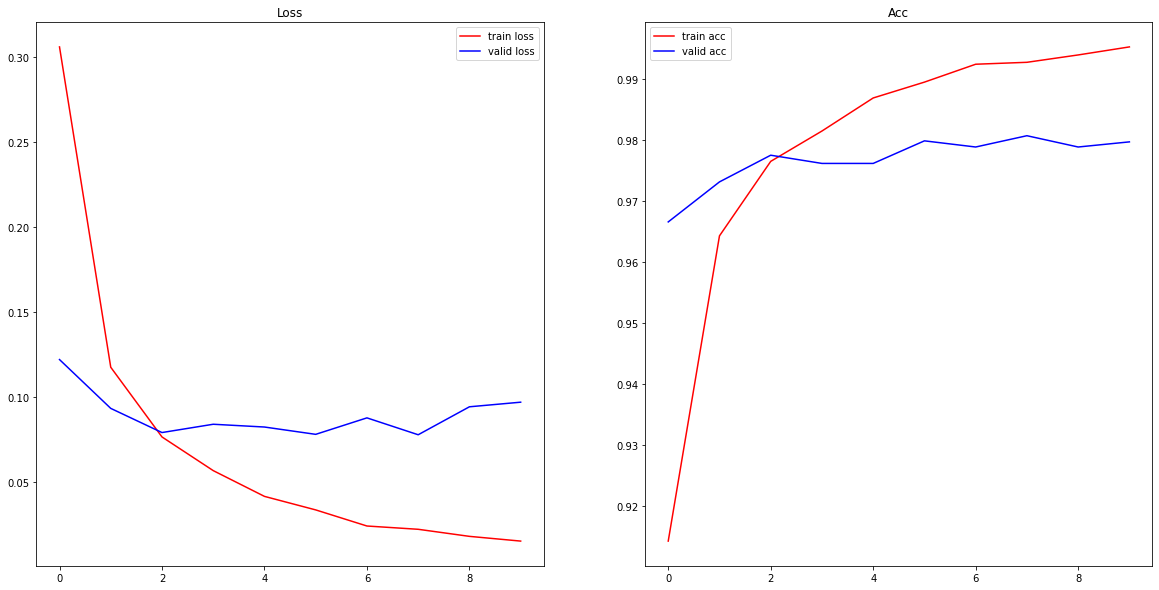

In [ ]:
device = "cuda"
trainer_mlp = Trainer(model=mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_mlp.test(test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
torch.save(mlp.state_dict(), os.path.join(model_dir, "Lion_MNIST_MLP_Classifier.pth"))

In [ ]:
class Lion_MNIST_MLP_Classifier_mini(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 33),
        nn.ReLU(),
        nn.Linear(33, 64),
        nn.ReLU(),
        nn.Linear(64, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
# 파라미터를 cnn과 똑같이 맟춰주기
mlp_mini = Lion_MNIST_MLP_Classifier_mini(n_class=10)
count_parameters(mlp_mini)

Model's state_dict:
   model.1.weight    torch.Size([33, 784])          25872
    model.1.bias     torch.Size([33])               33
   model.3.weight    torch.Size([64, 33])           2112
    model.3.bias     torch.Size([64])               64
   model.5.weight    torch.Size([10, 64])           640
    model.5.bias     torch.Size([10])               10
Model's total parameters : 28731


===== Train Start =====
Epoch: 0, train loss: 0.439662, train acc: 0.879763, valid loss: 0.197101, valid acc: 0.944556, time: 2.863061
Epoch: 1, train loss: 0.214735, train acc: 0.937074, valid loss: 0.167083, valid acc: 0.949933, time: 2.854707
Epoch: 2, train loss: 0.168655, train acc: 0.950864, valid loss: 0.143552, valid acc: 0.957661, time: 2.810064
Epoch: 3, train loss: 0.140876, train acc: 0.957944, valid loss: 0.127489, valid acc: 0.963542, time: 2.793835
Epoch: 4, train loss: 0.120980, train acc: 0.963671, valid loss: 0.121446, valid acc: 0.964046, time: 2.879902
Epoch: 5, train loss: 0.106703, train acc: 0.967953, valid loss: 0.117867, valid acc: 0.963878, time: 2.810491
Epoch: 6, train loss: 0.094977, train acc: 0.970733, valid loss: 0.113492, valid acc: 0.967238, time: 2.845428
Epoch: 7, train loss: 0.086074, train acc: 0.973717, valid loss: 0.111518, valid acc: 0.969758, time: 2.858719
Epoch: 8, train loss: 0.078956, train acc: 0.975849, valid loss: 0.114864, valid acc: 0.

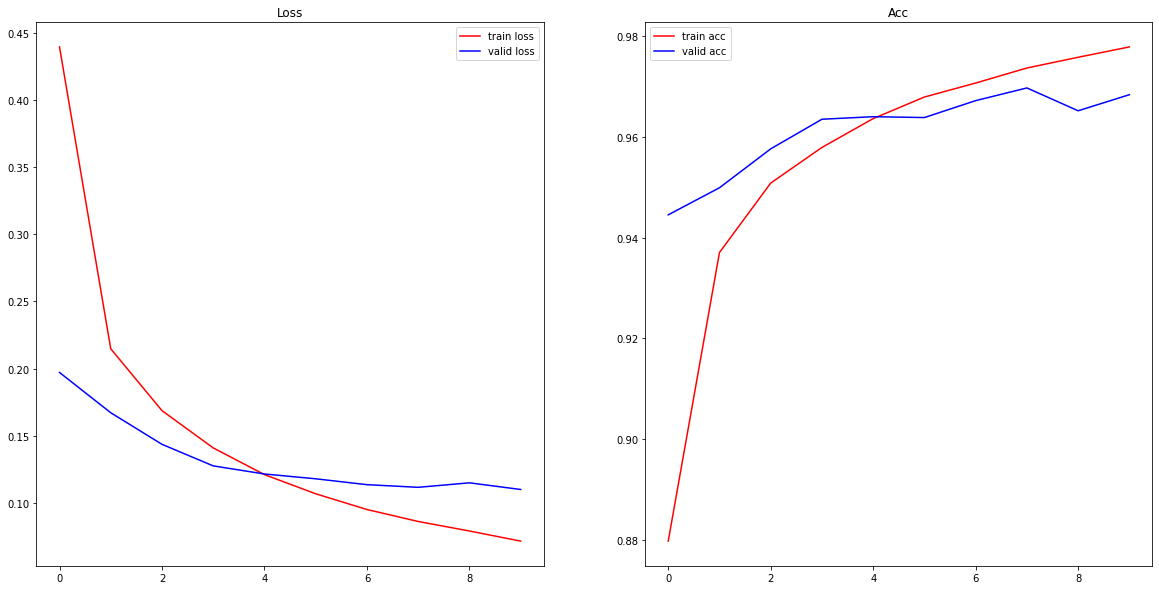

In [ ]:
trainer_mlp_mini = Trainer(model=mlp_mini, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp_mini.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_mlp_mini.test(test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    # model_dir 이 없을 경우 생성해줌
torch.save(mlp_mini.state_dict(), os.path.join(model_dir, "Lion_MNIST_MLP_Classifier_mini.pth"))

### CPU vs GPU
CPU : 명령어가 입력된 순서대로 데이터를 처리하는 직렬 처리 방식에 특화된 구조 --> 한 번에 한 가지의 명령만 처리함
GPU : 여러 명령어를 동시에 처리하는 병렬 처리 방식에 특화된 구조 --> 연산을 할 수 있는 코어가 많음

CNN : Convolution 연산 시 동일한 filter 값으로 픽셀을 옮겨가며 연산을 반복함

따라서 CNN은 병렬 처리에 강점이 있는 GPU를 사용하는 것이 유리하다

===== Train Start =====
Epoch: 0, train loss: 0.295347, train acc: 0.906083, valid loss: 0.077533, valid acc: 0.980175, time: 43.996249
Epoch: 1, train loss: 0.081925, train acc: 0.974403, valid loss: 0.065745, valid acc: 0.980007, time: 43.291624
Epoch: 2, train loss: 0.058610, train acc: 0.981446, valid loss: 0.048954, valid acc: 0.985719, time: 43.652140
Epoch: 3, train loss: 0.045595, train acc: 0.985728, valid loss: 0.045687, valid acc: 0.985047, time: 43.274667
Epoch: 4, train loss: 0.039042, train acc: 0.987452, valid loss: 0.042622, valid acc: 0.988071, time: 42.926221
Epoch: 5, train loss: 0.032222, train acc: 0.989861, valid loss: 0.039834, valid acc: 0.989919, time: 44.018737
Epoch: 6, train loss: 0.028330, train acc: 0.990770, valid loss: 0.039428, valid acc: 0.988911, time: 45.454634
Epoch: 7, train loss: 0.023723, train acc: 0.992123, valid loss: 0.032088, valid acc: 0.992103, time: 44.967731
Epoch: 8, train loss: 0.020091, train acc: 0.993327, valid loss: 0.029979, valid

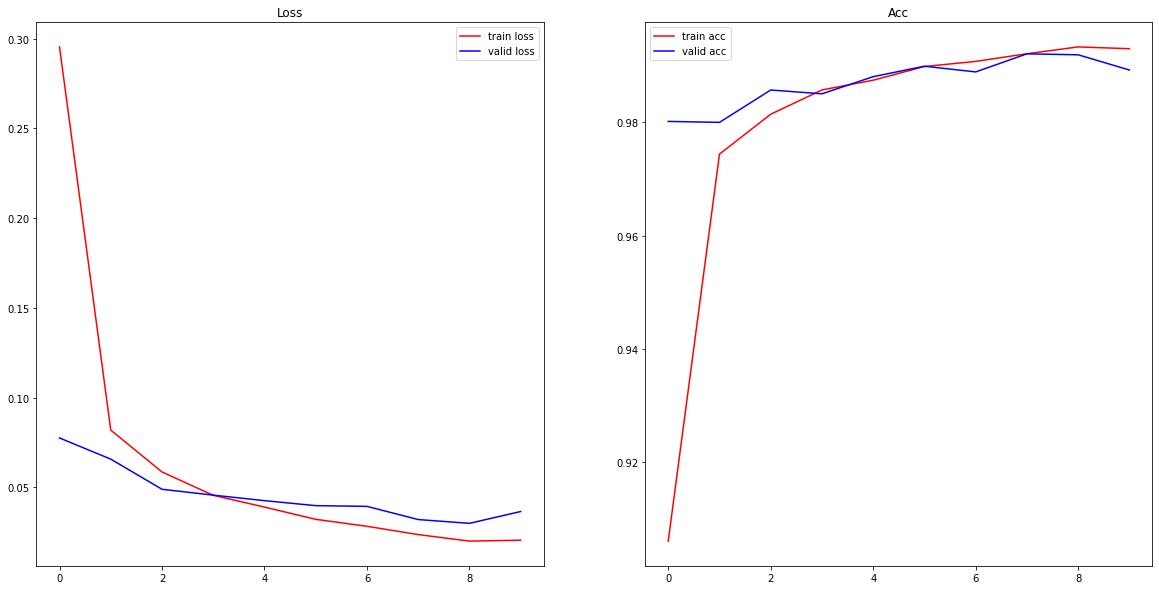

In [ ]:
# CNN CPU 학습속도
device = "cpu"
cnn = Lion_MNIST_CNN_Classifier(n_class=10)
trainer = Trainer(model=cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

In [ ]:
# CPU CNN inference 속도
trainer.test(test_loader)

===== Test Start =====
Test loss: 0.030915, Test acc: 0.989884, time: 3.889454


===== Train Start =====
Epoch: 0, train loss: 0.475311, train acc: 0.860784, valid loss: 0.210190, valid acc: 0.942876, time: 2.414241
Epoch: 1, train loss: 0.229161, train acc: 0.932977, valid loss: 0.163002, valid acc: 0.955477, time: 2.433612
Epoch: 2, train loss: 0.178453, train acc: 0.946434, valid loss: 0.142738, valid acc: 0.959509, time: 2.416194
Epoch: 3, train loss: 0.148360, train acc: 0.956183, valid loss: 0.130598, valid acc: 0.963542, time: 2.399232
Epoch: 4, train loss: 0.124770, train acc: 0.963097, valid loss: 0.117845, valid acc: 0.966902, time: 2.497629
Epoch: 5, train loss: 0.110332, train acc: 0.966730, valid loss: 0.113610, valid acc: 0.967406, time: 2.427669
Epoch: 6, train loss: 0.097889, train acc: 0.970511, valid loss: 0.107643, valid acc: 0.968918, time: 2.526757
Epoch: 7, train loss: 0.088323, train acc: 0.972976, valid loss: 0.114884, valid acc: 0.966902, time: 2.561810
Epoch: 8, train loss: 0.078896, train acc: 0.975311, valid loss: 0.115270, valid acc: 0.

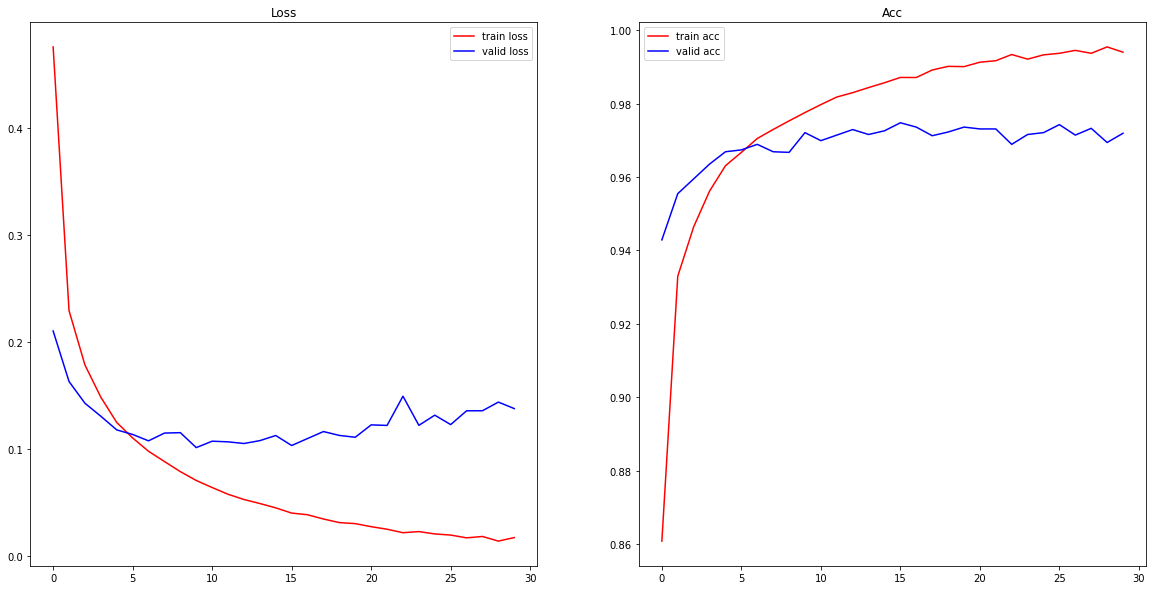

In [ ]:
# CPU MLP 학습속도
# 이경우는 gpu보다 빠름 그 이유는 하나하나의 크기가 크기에 똑똑한 cpu가 처리하는것이 빠른것임
mlp_mini = Lion_MNIST_MLP_Classifier_mini(n_class=10)
trainer_mlp_mini = Trainer(model=mlp_mini, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_mlp_mini.train(train_loader, valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

In [ ]:
# CPU MLP inference 속도
trainer_mlp_mini.test(test_loader)

===== Test Start =====
Test loss: 0.155097, Test acc: 0.968249, time: 0.781780


### Filter, Feature map visualization

In [ ]:
## 학습된 CNN Load

model_path = os.path.join(model_dir, "Lion_MNIST_CNN_Classifier.pth")
print(model_path)
cnn.load_state_dict(torch.load(model_path))
cnn.to(device)
cnn.eval()


/content/drive/MyDrive/Colab Notebooks/model/Lion_MNIST_CNN_Classifier.pth


Lion_MNIST_CNN_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

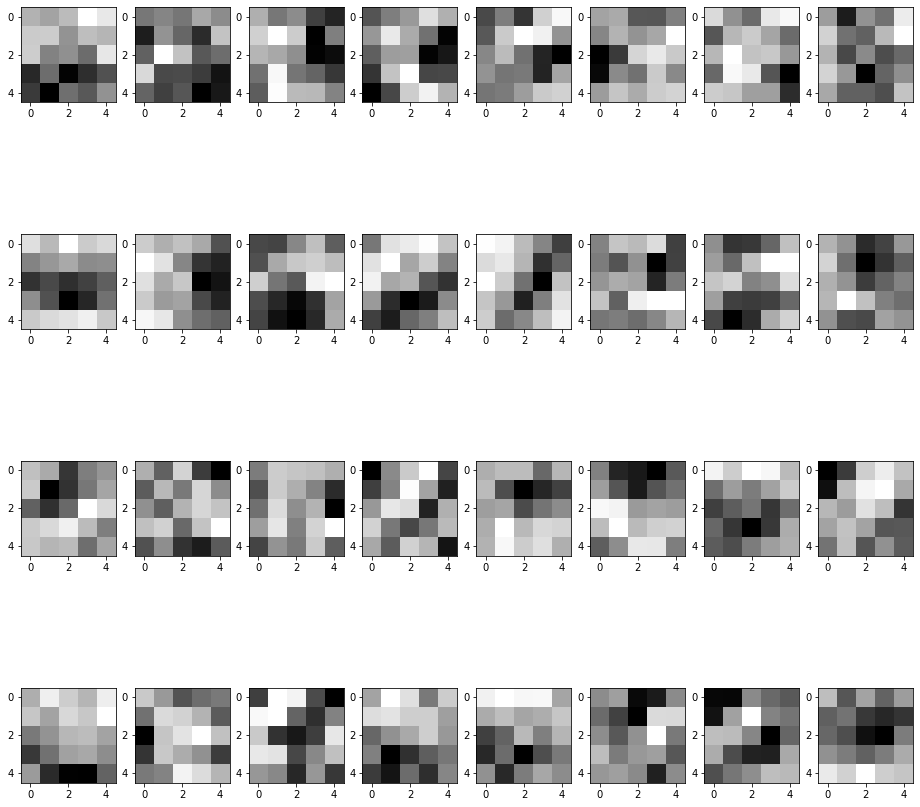

In [ ]:
## 학습된 CNN의 첫번째 conv layer filter 를 visualization

conv_filter = np.array(cnn.state_dict()['conv1.weight'].data.to("cpu"))
fig = plt.figure(figsize=(16, 16))
for i in range(32):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(conv_filter[i, 0], cmap="gray")
fig.show()

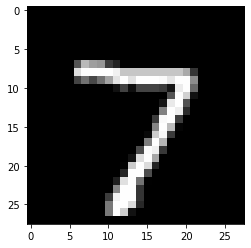

7


In [ ]:
## Sample Image 
sample_x, sample_y = mnist_test[0]  
f1, f2, f3, out = cnn(sample_x.unsqueeze(0).to(device), visualize_filter=True)

fig0 = plt.figure()
plt.imshow(np.array(sample_x.to("cpu").detach())[0], cmap="gray")
plt.show()
print(np.argmax(np.array(out.to("cpu").detach())))

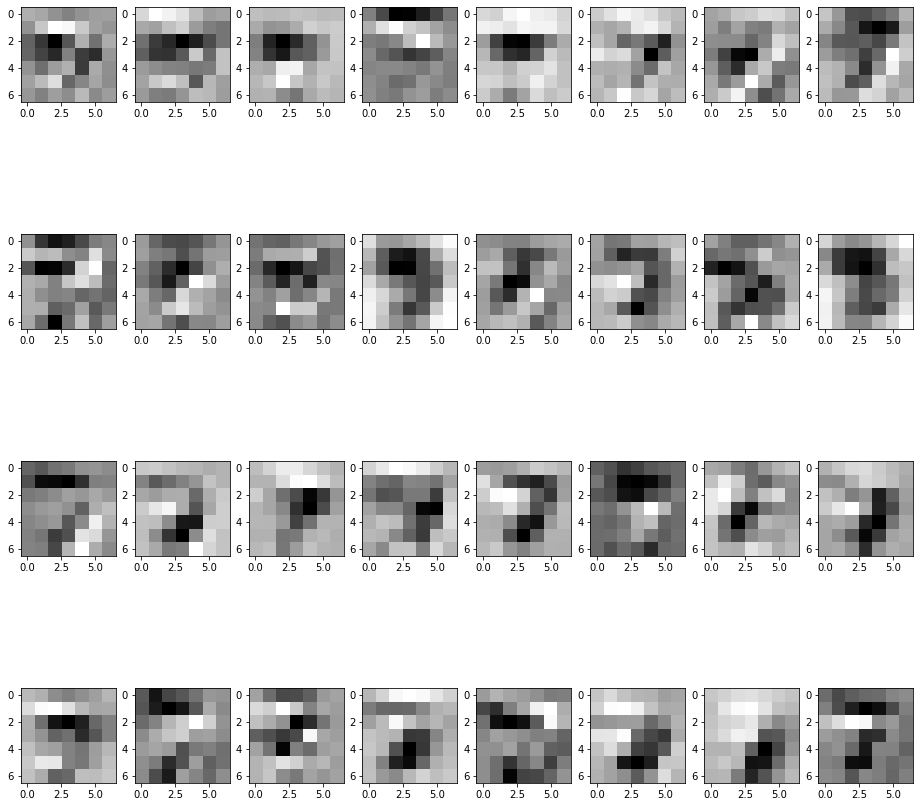

In [ ]:
## Sample Image 에 대해 feature map visualization

fig = plt.figure(figsize=(16, 16))
for i in range(32):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(np.array(f3.to("cpu").detach())[0, i], cmap="gray")
fig.show()

## 6-3. SVHN
The Street View House Number (SVHN) Dataset

MNIST 와 유사하게 0 ~ 9 의 이미지와 label 로 구성되어 있음

입력 이미지는 32x32x3 RGB 이미지

### Data load

In [ ]:
SVHN_train = datasets.SVHN(
    root=root, 
    split='train', 
    download=True, 
    transform=transforms.ToTensor()
) 
SVHN_test = datasets.SVHN(
    root=root, 
    split='test', 
    download=True, 
    transform=transforms.ToTensor()
) 

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
print(SVHN_train)
print(SVHN_train[0])
sample_x, sample_y = SVHN_train[0]
print(sample_x.shape)
print(sample_y)

Dataset SVHN
    Number of datapoints: 73257
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: train
    StandardTransform
Transform: ToTensor()
(tensor([[[0.1294, 0.0588, 0.0588,  ..., 0.2824, 0.3216, 0.3490],
         [0.1098, 0.0549, 0.0549,  ..., 0.1569, 0.2627, 0.3255],
         [0.1569, 0.0706, 0.0627,  ..., 0.0902, 0.1373, 0.2824],
         ...,
         [0.3373, 0.3412, 0.3216,  ..., 0.4078, 0.4078, 0.4039],
         [0.3294, 0.3373, 0.3216,  ..., 0.4314, 0.4157, 0.4157],
         [0.3333, 0.3490, 0.3333,  ..., 0.4353, 0.4275, 0.4039]],

        [[0.1176, 0.0902, 0.0667,  ..., 0.2549, 0.3020, 0.3098],
         [0.1529, 0.0980, 0.0784,  ..., 0.1529, 0.2275, 0.3059],
         [0.1608, 0.0824, 0.0667,  ..., 0.1137, 0.1647, 0.2706],
         ...,
         [0.3176, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4118],
         [0.3373, 0.3098, 0.2980,  ..., 0.4039, 0.4118, 0.4078],
         [0.3451, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4157]],

        [[0.1490, 

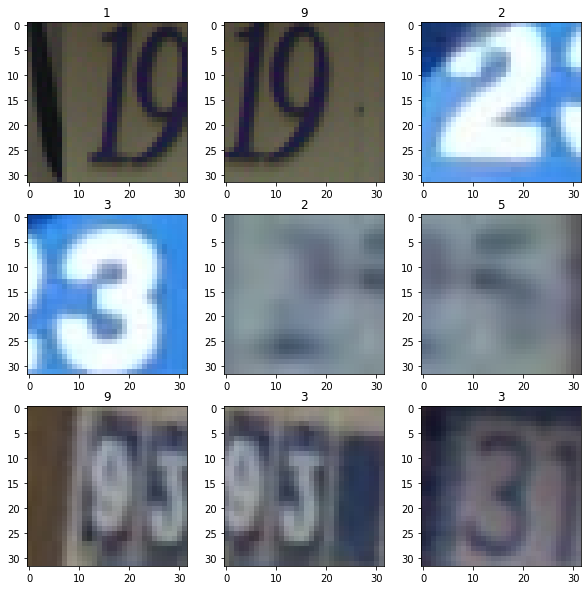

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  img = SVHN_train[i][0]
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img.permute(1, 2, 0))
  ax.title.set_text(SVHN_train[i][1])
fig.show()

In [ ]:
# SVHN DataLoader 생성

from torch.utils.data import random_split

random_seed = 0
torch.manual_seed(random_seed)

val_size = int(len(SVHN_train) * 0.1)
train_size = len(SVHN_train) - val_size

SVHN_train, SVHN_valid = random_split(SVHN_train, [train_size, val_size])
print(len(SVHN_train), len(SVHN_valid))

# DataLoader 정의
SVHN_train_loader = DataLoader(dataset=SVHN_train, batch_size=64, shuffle=True, drop_last=True)    # train 시에는 데이터를 shuffle 해줌
SVHN_valid_loader = DataLoader(dataset=SVHN_valid, batch_size=64, shuffle=False, drop_last=True)   
SVHN_test_loader = DataLoader(dataset=SVHN_test, batch_size=64, shuffle=False, drop_last=True)

65932 7325


In [ ]:
## 간단한 CNN, MLP Classifier 모델

class Lion_SVHN_CNN_Classifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

    
  def forward(self, x, visualize_filter=False):

    out = self.model(x)

    return out

class Lion_SVHN_MLP_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2048),
        nn.ReLU(),
        nn.Linear(1024, 10),
    )

  def forward(self, x):
    return self.model(x)


In [ ]:
svhn_cnn = Lion_SVHN_CNN_Classifier()
svhn_mlp = Lion_SVHN_MLP_Classifier()

count_parameters(svhn_cnn)
count_parameters(svhn_mlp)

Model's state_dict:
   model.0.weight    torch.Size([32, 3, 3, 3])      864
    model.0.bias     torch.Size([32])               32
   model.2.weight    torch.Size([64, 32, 3, 3])     18432
    model.2.bias     torch.Size([64])               64
   model.5.weight    torch.Size([128, 64, 3, 3])    73728
    model.5.bias     torch.Size([128])              128
   model.7.weight    torch.Size([128, 128, 3, 3])   147456
    model.7.bias     torch.Size([128])              128
  model.10.weight    torch.Size([256, 128, 3, 3])   294912
   model.10.bias     torch.Size([256])              256
  model.12.weight    torch.Size([256, 256, 3, 3])   589824
   model.12.bias     torch.Size([256])              256
  model.16.weight    torch.Size([512, 4096])        2097152
   model.16.bias     torch.Size([512])              512
  model.18.weight    torch.Size([512, 512])         262144
   model.18.bias     torch.Size([512])              512
  model.20.weight    torch.Size([10, 512])          5120
   model.

===== Train Start =====
Epoch: 0, train loss: 2.238738, train acc: 0.189533, valid loss: 2.241918, valid acc: 0.182566, time: 24.387615
Epoch: 1, train loss: 2.236883, train acc: 0.189973, valid loss: 2.242228, valid acc: 0.182566, time: 24.369689
Epoch: 2, train loss: 2.236789, train acc: 0.189973, valid loss: 2.243552, valid acc: 0.182566, time: 24.269327
Epoch: 3, train loss: 2.236559, train acc: 0.189927, valid loss: 2.243164, valid acc: 0.182566, time: 24.442635
Epoch: 4, train loss: 2.236643, train acc: 0.190003, valid loss: 2.242356, valid acc: 0.182566, time: 24.124877
Epoch: 5, train loss: 2.236574, train acc: 0.189958, valid loss: 2.242037, valid acc: 0.182566, time: 24.234251
Epoch: 6, train loss: 2.236616, train acc: 0.189973, valid loss: 2.241993, valid acc: 0.182566, time: 24.121895
Epoch: 7, train loss: 2.236464, train acc: 0.189988, valid loss: 2.242834, valid acc: 0.182566, time: 24.135861
Epoch: 8, train loss: 2.236486, train acc: 0.189958, valid loss: 2.242222, valid

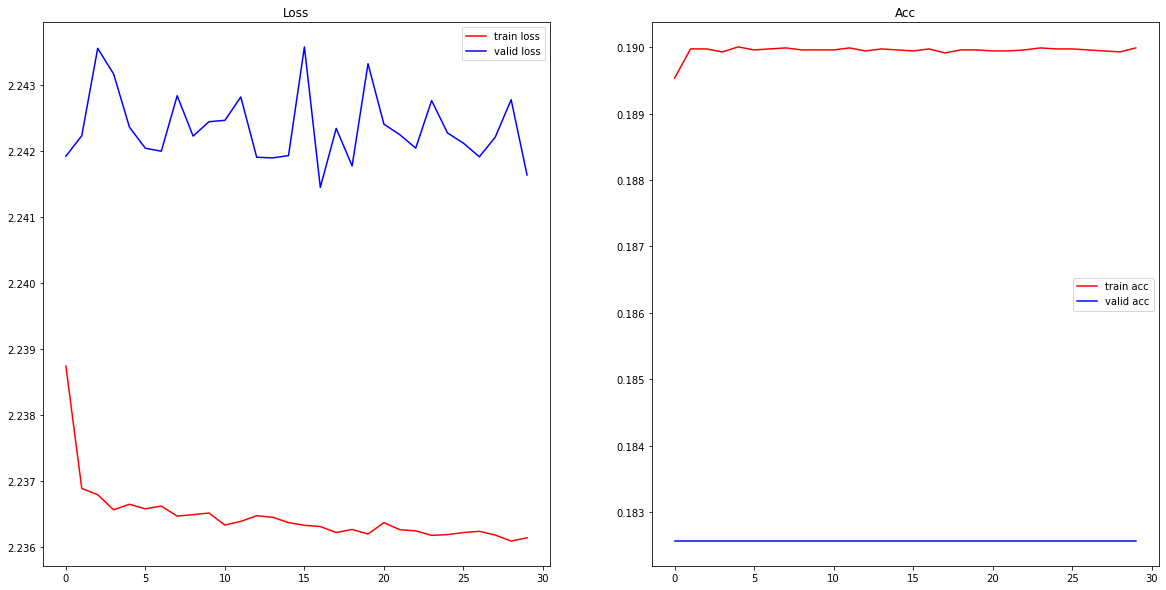

In [ ]:
device = "cuda"
trainer_svhn_cnn = Trainer(model=svhn_cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_svhn_cnn.train(SVHN_train_loader, SVHN_valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_svhn_cnn.test(SVHN_test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    
torch.save(svhn_cnn.state_dict(), os.path.join(model_dir, "Lion_SVHN_CNN_Classifier.pth"))

In [ ]:
model_path = os.path.join(model_dir, "Lion_SVHN_CNN_Classifier.pth")
print(model_path)
svhn_cnn.load_state_dict(torch.load(model_path))
svhn_cnn.eval()

# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=svhn_cnn, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(SVHN_test_loader)

/content/drive/MyDrive/Colab Notebooks/model/Lion_SVHN_CNN_Classifier.pth
===== Test Start =====
Test loss: 2.223936, Test acc: 0.195851, time: 5.169080


In [ ]:
trainer_svhn_mlp = Trainer(model=svhn_mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer_svhn_mlp.train(SVHN_train_loader, SVHN_valid_loader, max_epochs=30, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")
trainer_svhn_mlp.test(SVHN_test_loader)

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir): os.makedirs(model_dir)    
torch.save(svhn_mlp.state_dict(), os.path.join(model_dir, "Lion_SVHN_MLP_Classifier.pth"))

===== Train Start =====


RuntimeError: ignored

In [ ]:
model_path = os.path.join(model_dir, "Lion_SVHN_MLP_Classifier.pth")
print(model_path)
svhn_mlp.load_state_dict(torch.load(model_path))
svhn_mlp.eval()

# Load 한 model test 성능

device = "cuda"
trainer_load = Trainer(model=svhn_mlp, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(SVHN_test_loader)

/content/drive/MyDrive/Colab Notebooks/model/Lion_SVHN_MLP_Classifier.pth


RuntimeError: ignored